# Spark Cluster

## Setup


In [ ]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, asc, desc, max, hour, avg, date_format, rank
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.types import TimestampType, DateType
from pyspark.sql.window import Window

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1763051265535_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
spark = SparkSession.builder.getOrCreate()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
%%configure -f
{
    "conf": {
        "spark.pyspark.python": "python3",
        "spark.pyspark.virtualenv.enabled": "true",
        "spark.pyspark.virtualenv.type":"native",
        "spark.pyspark.virtualenv.bin.path":"/usr/bin/virtualenv"
    }
}

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1763051265535_0002,pyspark,idle,,,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
1,application_1763051265535_0002,pyspark,idle,Link,Link,None,✔


In [ ]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("numpy")
sc.install_pypi_package("matplotlib")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.1
    Not uninstalling python-dateutil at /usr/lib/python3.9/site-packages, outside environment /mnt1/yarn/usercache/livy/appcache/application_1763051265535_0002/container_1763051265535_0002_01_000001/tmp/spark-430d6778-0986-46f5-90cd-31f68c855236
    Can't uninstall 'python-dateutil'. No files were found to uninstall.



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
matplotlib 3.9.4 requires contourpy>=1.0.1, which is not installed.
matplotlib 3.9.4 requires cycler>=0.10, which is not installed.
matplotlib 3.9.4 requires fonttools>=4.22.0, which is not installed.
matplotlib 3.9.4 requires importlib-resources>=3.2.0; python_version < "3.10", which is not installed.
matplotlib 3.9.4 requires kiwisolver>=1.3.1, which is not installed.
matplotlib 3.9.4 requires pillow>=8

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Data

Reading OpenAQ data from AWS S3

OpenAQ project: https://openaq.org/

Registry of AWS Open Data: https://registry.opendata.aws/openaq/

S3 bucket structure: https://docs.openaq.org/aws/about

In [ ]:
smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=100*/year=2022/month=05/location-100*-2022050*.csv.gz")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
smog_df.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1500

In [ ]:
smog_df.sample(fraction=0.01).limit(10).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----------+--------------------------+-------------------------+----------------+----------------+---------+-----+------+
|location_id|sensors_id|location                  |datetime                 |lat             |lon             |parameter|units|value |
+-----------+----------+--------------------------+-------------------------+----------------+----------------+---------+-----+------+
|100        |4147      |Badhoevedorp-Sloterweg-100|2022-05-07T06:00:00+02:00|52.334          |4.77401         |pm25     |µg/m³|-999.0|
|100        |162       |Badhoevedorp-Sloterweg-100|2022-05-05T02:00:00+02:00|52.334          |4.77401         |co       |µg/m³|-999.0|
|100        |4147      |Badhoevedorp-Sloterweg-100|2022-05-03T02:00:00+02:00|52.334          |4.77401         |pm25     |µg/m³|20.9  |
|1006       |1813      |Painesville-1006          |2022-05-07T03:00:00-04:00|41.726811       |-81.242156      |pm25     |µg/m³|4.2   |
|1006       |1812      |Painesville-1006          |2022

### Using extended locations data

Data in the S3 bucket contains only a few necessary fields -- parameter readings and a limited information about sensor locations.

Additional information are available through OpenAQ API: https://api.openaq.org/

File openaq_locations.json contains extended information about locations which was downloaded using this REST API.

Data from this file joined with data in S3 can be used for more advanced queries.

In [ ]:
df = spark.read.option("multiLine", "true").json("s3a://openaqlocationsadzd/openaq_locations.json")
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+----------------+-------------+------------+--------+---+--------------------+--------+---------+--------+--------+-------------------+--------------------+--------------------+--------------------+------------+
|              bounds|         coordinates|         country|datetimeFirst|datetimeLast|distance| id|         instruments|isMobile|isMonitor|licenses|locality|               name|               owner|            provider|             sensors|    timezone|
+--------------------+--------------------+----------------+-------------+------------+--------+---+--------------------+--------+---------+--------+--------+-------------------+--------------------+--------------------+--------------------+------------+
|[-0.19968, 5.5838...| {5.58389, -0.19968}|{GH, 152, Ghana}|         NULL|        NULL|    NULL|  3|[{2, Government M...|   false|     true|    NULL|    NULL|         NMA - Nima|{4, Unknown Gover...|{209, Dr. Raphael...|[{6, pm10 µg/m³

In [ ]:
locations_df = df.select(
    "id",
    "name",
    "timezone",
    df["country.code"].alias("country_code"),
    df["country.name"].alias("country_name"),
)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
locations_df.sample(fraction=0.01).show(truncate=False)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+---------------------------+-------------------+------------+-------------+
|id  |name                       |timezone           |country_code|country_name |
+----+---------------------------+-------------------+------------+-------------+
|42  |SPARTAN - Ilorin University|Africa/Lagos       |NG          |Nigeria      |
|234 |Enterprise - US Fore       |America/Los_Angeles|US          |United States|
|258 |Trimble                    |America/Chicago    |US          |United States|
|597 |Miami Jones Ranch          |America/Phoenix    |US          |United States|
|706 |Calabozo                   |America/Santiago   |CL          |Chile        |
|817 |Beaver Falls               |America/New_York   |US          |United States|
|1005|Paia, Maui                 |Pacific/Honolulu   |US          |United States|
|1007|Pak Phriao, Mueang         |Asia/Bangkok       |TH          |Thailand     |
|1073|Hamilton Downtown          |America/Toronto    |CA          |Canada       |
|1085|Isla Blanc

In [ ]:
locations_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- id: long (nullable = true)
 |-- name: string (nullable = true)
 |-- timezone: string (nullable = true)
 |-- country_code: string (nullable = true)
 |-- country_name: string (nullable = true)

## Big data cluster computations

1. Perform calculations for task 2: Create a query that calculates the average concentration of a chosen parameter for each hour of the day (0-1, 1-2, ..., 23-24) for every location, and finds the hour at which this average was highest.
2. Calculate time of execution for 2, 3, 4, 5, 6, 7 worker instances
3. Create execution time, speedup and efficiency plots.

In [ ]:
def get_valid_s3_paths(location_ids, spark_session, target_count=30):
    valid_paths = []
    for loc_id in location_ids:
        path = f"s3a://openaq-data-archive/records/csv.gz/locationid={loc_id}/year=2022/month={{01,02,03,04,05,06,07,08,09,10}}/*.csv.gz"
        try:
            spark_session.read.format("csv").option("compression", "gzip").option("header", True).load(path)
            valid_paths.append(path)
            #print(f"Found valid path for location ID: {loc_id}")
        except Exception as e:
            if "PATH_NOT_FOUND" in str(e):
                pass
            else:
                print(f"Error loading data for location ID {loc_id}: {e}")

        if len(valid_paths) >= target_count:
            break

    return valid_paths

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from functools import reduce
from pyspark.sql import DataFrame

def get_df_from_paths(s3_paths, spark_session, locations_df):
    if not s3_paths:
        return None

    correct_dfs = []
    for path in s3_paths:
      dframes = spark_session \
          .read \
          .format("csv") \
          .option("compression", "gzip") \
          .option("header", True) \
          .load(path)
      correct_dfs.append(dframes)

    df_all = reduce(DataFrame.unionByName, correct_dfs)

    df_typed = (
        df_all
        .withColumn("value", col("value").cast("double"))
        .withColumn("location_id", col("location_id").cast("long"))
        .withColumn("datetime", col("datetime").cast("timestamp"))
    )

    df_final = df_typed.join(
        locations_df.select("id", "name"),
        df_typed.location_id == locations_df.id,
        how='left'
    ).drop(locations_df.id)

    return df_final


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, asc, desc, max, hour, avg, date_format, rank
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.types import TimestampType, DateType
from pyspark.sql.window import Window

start = time.time()

pl_locations_df = locations_df.filter(locations_df.country_code == 'PL').select('name', 'id')
pl_location_ids = pl_locations_df.select("id").rdd.flatMap(lambda x: x).collect()
pl_100 = get_valid_s3_paths(pl_location_ids, spark, target_count=100)
df_final = get_df_from_paths(pl_100, spark, pl_locations_df)

PARAMETER = "co"

hour_avg_co = df_final \
  .filter(col("parameter") == PARAMETER) \
  .groupBy(
    col("name"),
    hour(col("datetime")).alias("hour")
  ) \
  .agg(avg(col("value")).alias("avg_value"))

w = Window.partitionBy('name')

hour_avg_co_with_max = hour_avg_co.withColumn('max_avg_value', max('avg_value').over(w))

highest_avg_hour_per_location = hour_avg_co_with_max.filter(col('avg_value') == col('max_avg_value')).drop('max_avg_value')

end = time.time()
print(end - start)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

211.49179911613464

## Plotting

In [3]:
workers = np.array([1, 2, 3, 4, 5, 6, 7])
times = np.array([328.2851402759552, 217.86312818527222, 182.61667442321777, 210.5596935749054, 183.47686576843262, 179.35194444656372, 211.49179911613464]) #update data
speedups = times[0]/times
efficiencies = speedups / workers

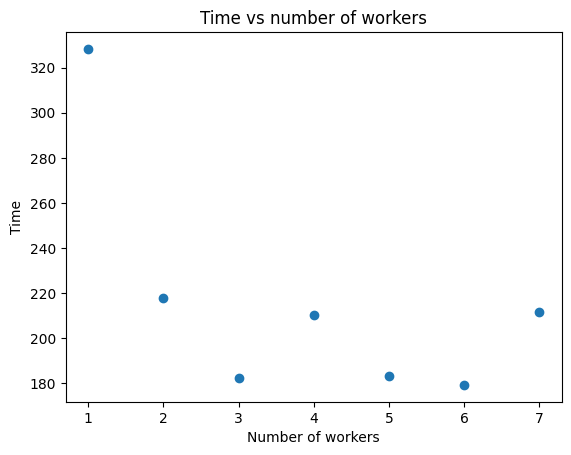

In [5]:
plt.scatter(workers, times)
plt.xlabel("Number of workers")
plt.ylabel("Time")
plt.title("Time vs number of workers")
plt.show()
%matplot plt

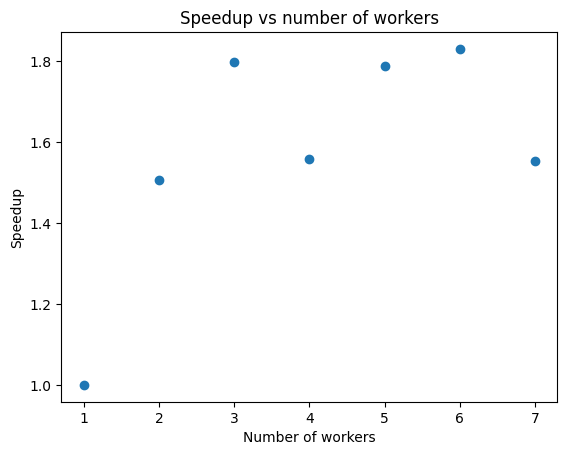

In [7]:
plt.clf()
plt.scatter(workers, speedups)
plt.xlabel("Number of workers")
plt.ylabel("Speedup")
plt.title("Speedup vs number of workers")
plt.show()
%matplot plt

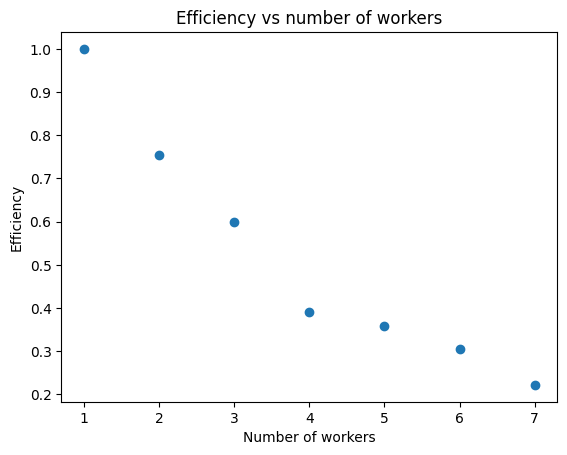

In [8]:
plt.clf()
plt.scatter(workers, efficiencies)
plt.xlabel("Number of workers")
plt.ylabel("Efficiency")
plt.title("Efficiency vs number of workers")
plt.show()
%matplot plt